In [ ]:
import os

# Import installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Scikit-Learn stuff
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

# Keras
import tensorflow.keras as keras
import tensorflow as tf

# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "path name"
except ModuleNotFoundError:
    core_path = ""

# Load the level 2 asteroid data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

# Allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())
asteroids_y_bus = np.array(asteroids_df["Bus_Class"].to_list())

Mounted at /gdrive


In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

for train_index, test_index in sss.split(asteroids_X, asteroids_y):

    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]
    y_train_bus, y_test_bus = asteroids_y_bus[train_index], asteroids_y_bus[test_index]

In [ ]:
from sklearn import preprocessing

# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the training data to fit
# the scaler
scaler = preprocessing.StandardScaler().fit(X_train)

# Transform now the training data
X_train_scaled = scaler.transform(X_train)

# Scale the testing data ...
X_test_scaled = scaler.transform(X_test)

# And expanding the dimensionality for our ConvNet-based Autoencoder
X_train_scaled = np.expand_dims(X_train_scaled, axis=2)
X_test_scaled = np.expand_dims(X_test_scaled, axis=2)

In [ ]:
import keras
from keras.layers import Input, Conv1D, Conv1DTranspose, LeakyReLU, BatchNormalization, Flatten, Dense, Reshape
from keras.models import Model
from keras.optimizers import Adam

n_inputs = asteroids_X.shape[1]
n_bottleneck = 2

def create_model():
    input_layer = Input(shape=(n_inputs, 1))
    x = BatchNormalization()(input_layer)  # Add batch normalization

    x = Conv1D(filters=16, kernel_size=3, activation=LeakyReLU(alpha=0.2), padding="same")(x)
    x = Conv1D(filters=32, kernel_size=3, activation=LeakyReLU(alpha=0.2), padding="same")(x)

    bottleneck_lay = Flatten()(x)
    bottleneck_lay = Dense(n_bottleneck)(bottleneck_lay)

    reset_lay = Dense(49 * 32)(bottleneck_lay)
    reshape_lay = Reshape((49, 32))(reset_lay)

    x = Conv1DTranspose(filters=32, kernel_size=3, strides=1, activation=LeakyReLU(alpha=0.2), padding="same")(reshape_lay)
    x = Conv1DTranspose(filters=16, kernel_size=3, strides=1, activation=LeakyReLU(alpha=0.2), padding="same")(x)

    output_layer = Conv1D(1, 1, padding="same")(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    encoder_model = Model(inputs=input_layer, outputs=bottleneck_lay)

    return model, encoder_model

model, encoder_model = create_model()

# Use a custom optimizer with a specific learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 49, 1)]           0         
                                                                 
 batch_normalization (Batch  (None, 49, 1)             4         
 Normalization)                                                  
                                                                 
 conv1d (Conv1D)             (None, 49, 16)            64        
                                                                 
 conv1d_1 (Conv1D)           (None, 49, 32)            1568      
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 2)                 3138      
                                                             

In [ ]:
end_epoch = 500
batch_size = 32

# Early Stopping for our final model
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train_scaled, X_train_scaled,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=0,
                    validation_split=0.25,
                    callbacks=[es_callback])

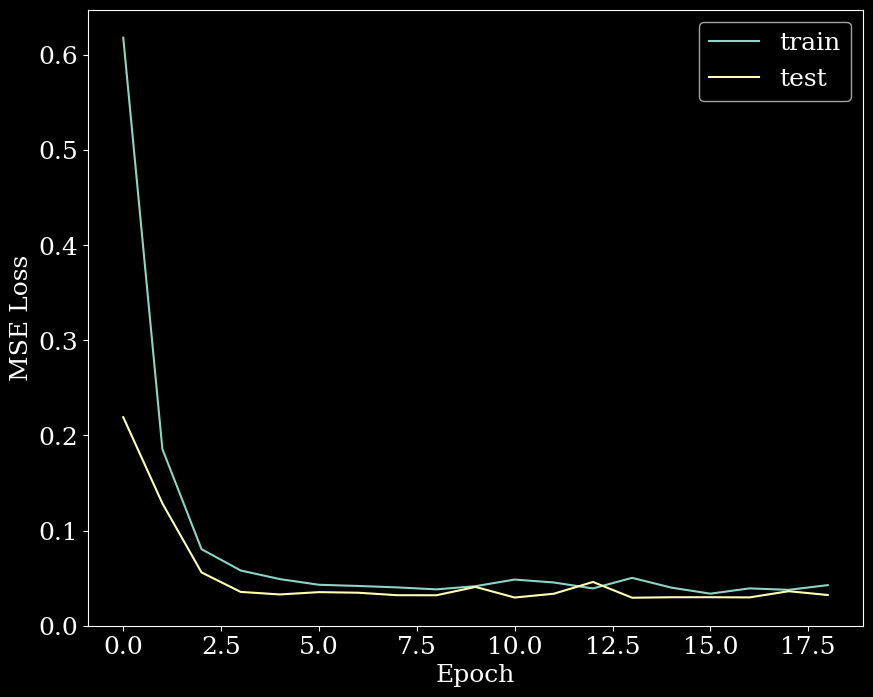

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

# Add legend and labels
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

# ... aaaaand plot!
plt.show()

34/34 [==============================] - 0s 2ms/step


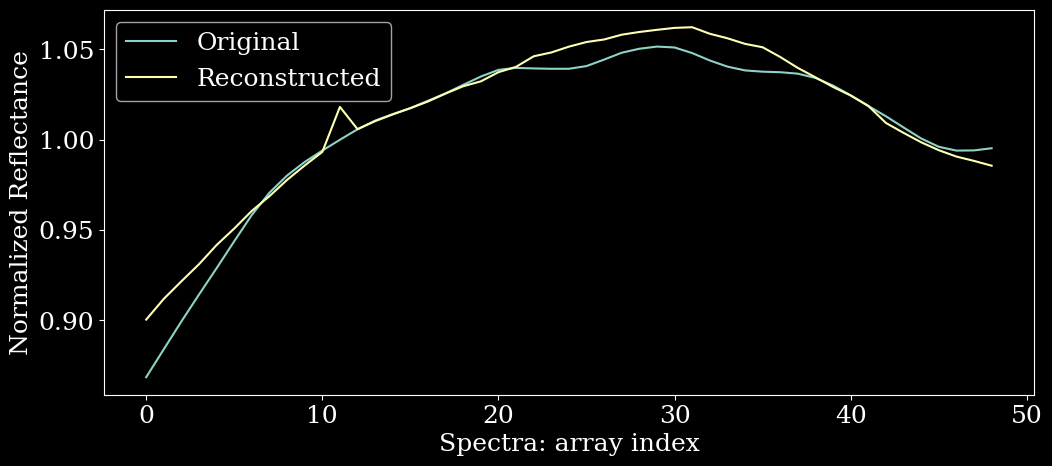

In [ ]:
index_val = 5

# Original signal
org_signal = scaler.inverse_transform(X_train_scaled[index_val].reshape(1, -1))[0]
# Reconstructed signal
rec_signal = scaler.inverse_transform(model.predict(X_train_scaled)[index_val].reshape(1, -1))[0]

# plot the training and reconstructed data
plt.figure(figsize=(12,5))
plt.plot(org_signal, label='Original')
plt.plot(rec_signal, label='Reconstructed')

# Add legend and labels
plt.legend()
plt.xlabel("Spectra: array index")
plt.ylabel("Normalized Reflectance")

plt.show()

In [ ]:
X_train_encoded = encoder_model.predict(X_train_scaled)
X_test_encoded = encoder_model.predict(X_test_scaled)

# Merge the data
X_encoded = np.vstack((X_train_encoded, X_test_encoded))
y_main = np.hstack((y_train, y_test))
y_bus = np.hstack((y_train_bus, y_test_bus))

# Create the dataframe
encoded_df = pd.DataFrame(np.hstack((X_encoded,
                                     y_main[np.newaxis].transpose(),
                                     y_bus[np.newaxis].transpose())),
                          columns=["enc1", "enc2", "Main_Group", "Bus_Class"])

# Change the dtype to float
encoded_df.loc[:, "enc1"] = encoded_df["enc1"].astype(float)
encoded_df.loc[:, "enc2"] = encoded_df["enc2"].astype(float)

9/9 [==============================] - 0s 2ms/step


<ipython-input-11-50ca5af38181>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  encoded_df.loc[:, "enc1"] = encoded_df["enc1"].astype(float)
<ipython-input-11-50ca5af38181>:17: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  encoded_df.loc[:, "enc2"] = encoded_df["enc2"].astype(float)


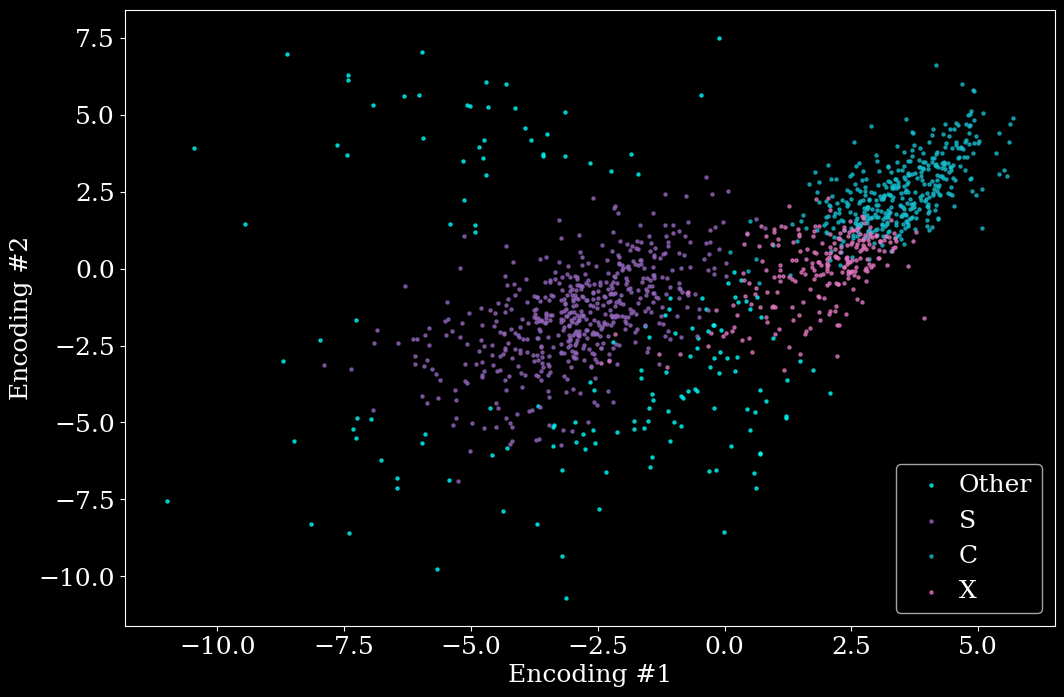

In [ ]:
color_dict = {'Other': 'aqua',
              'S': 'tab:purple',
              'C': 'tab:cyan',
              'X': 'tab:pink'}

# Set a plot
plt.figure(figsize=(12,8))

# Create a scatter plot with the encoder values and assign the colors to the corresponding classes
for asteroid_class, cluster_color in color_dict.items():
    plt.scatter(encoded_df.loc[encoded_df["Main_Group"] == asteroid_class]["enc1"],
                encoded_df.loc[encoded_df["Main_Group"] == asteroid_class]["enc2"],
                marker='o',
                s=5,
                alpha=0.7,
                color=cluster_color,
                label=asteroid_class)

# Set xlabels
plt.xlabel("Encoding #1")
plt.ylabel("Encoding #2")

plt.legend()

ax = plt.gca()
ax.legend(handletextpad=0.1)

plt.show()

In [ ]:
%matplotlib inline
import ipywidgets

# In our plot we will plot only the "top 20" Bus Classes (sorted by number)
top_bus = encoded_df.groupby('Bus_Class')['Main_Group'].count().nlargest(20)
bus_classes = sorted(top_bus.index)

# Filter the dataframe
encoded_train_df = encoded_df[encoded_df["Bus_Class"].isin(top_bus.index)].copy()

# Get a list of all Bus Classes
bus_classes = sorted(encoded_df["Bus_Class"].unique())

# Create a Selection widget
# Note: Press Shift or Cntrl (Windows) / CMD (MacOS) to choose multiple classes
selector = ipywidgets.SelectMultiple(options = bus_classes,
                                     value = [bus_classes[0]],
                                     rows = 10,
                                     description = 'Variables',
                                     disabled = False)

# Get the selected items
output = ipywidgets.Output()
display(selector)
display(output)

# Create a colormap, the colors and create a color dictionary
cmap = plt.get_cmap('tab20')
colors = cmap(np.linspace(0, 1, len(bus_classes)))
for k, c in zip(bus_classes, colors):
    color_dict[k] = c

# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

# Set a function for the (interactive) plots
def plot_encoding(widg):

    # Get the selected choices
    choices = widg['new']

    # Filter the dataframe based on the selection
    data = encoded_df.loc[encoded_df["Bus_Class"].isin(choices)] if choices \
               else encoded_df
    output.clear_output(wait=True)

    with output:

        # Create a "wide screen figure"
        fig, ax = plt.subplots(figsize=(20,8))

        # Plot the encoding values within a for loop to create easily a legend for each group
        for bus_k in np.unique(data["Bus_Class"]):

            ax.scatter(data.loc[data["Bus_Class"] == bus_k]["enc1"],
                       data.loc[data["Bus_Class"] == bus_k]["enc2"],
                       marker = 'o',
                       s = 15,
                       alpha = 0.7,
                       color = color_dict.get(bus_k),
                       label = bus_k)

        # Create the legend
        ax.legend()

        # Set labels
        plt.xlabel("Encoding #1")
        plt.ylabel("Encoding #2")

        # Set limits
        plt.xlim(np.min(encoded_df["enc1"]), np.max(encoded_df["enc1"]))
        plt.ylim(np.min(encoded_df["enc2"]), np.max(encoded_df["enc2"]))

        plt.show()

# Create an interactive session!
selector.observe(plot_encoding, names='value')

SelectMultiple(description='Variables', index=(0,), options=('A', 'B', 'C', 'Cb', 'Cg', 'Cgh', 'Ch', 'D', 'K',…

Output()